In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

In [164]:
wf_30_var2060=pd.read_csv("data/WF_L030_W1R_TI_High_VEL020_060_fs1000.csv")
wf_60_cte20=pd.read_csv("data/WF_L060_W1R_TI_High_VEL020_fs1000.csv")
wf_30_cte20=pd.read_csv("data/L030_TI_High_VEL020_fs1000.csv")

wf_30_var2060_27000 = wf_30_var2060.tail(27001)
wf_30_var2060_27000.reset_index(drop=True, inplace=True)

WF_Sx=(wf_30_cte20,wf_60_cte20,wf_30_var2060)
#WF_Sx=(wf_30_cte20,wf_60_cte20,wf_30_var2060_27000)

WF_Sx[-1].tail()

,t [s],az NO FLAT [m/s2],az WITH FLAT [m/s2]
32666,32.666,-9.044627,-9.042926
32667,32.667,-9.052778,-9.004735
32668,32.668,-9.007271,-9.034662
32669,32.669,-8.987924,-8.993435
32670,32.670,-8.975827,-9.044008


In [100]:
def gen_G(f_fail, fs, N, Λ=10, D_lambda=1/16):
    K=int(Λ/D_lambda)
    Ts=1/fs
    λs=np.arange(0,Λ,D_lambda)
    G=np.zeros((K,N),dtype=np.complex128)
    for k in range(K):
        G[k,:]=np.exp(-1j*2*np.pi*D_lambda*k*Ts*np.cumsum(f_fail))
    return G

def calc_Xlambda(G, Sx):
    return (1/Sx.shape[0])*np.dot(G, Sx)

def matricial_IGD(f_fail, fs, Sx_env, Λ=10, D_lambda=1/16):
    G=gen_G(f_fail, fs, Sx_env.shape[0], Λ, D_lambda)
    Sx_env=Sx_env-np.mean(Sx_env)
    Sx_env_analytic=signal.hilbert(Sx_env)
    X_lambda = calc_Xlambda(G, Sx_env_analytic)
    return X_lambda

####  Wheel Flat
##### Index 0: Constant Speed 20 km/h, L=30 mm
##### Index 1: Constant Speed 20 km/h, L=60 mm
##### Index 2: Speed Increases Linearly from 20 to 60 km/h, L=30 mm

In [165]:
index = 2

t = WF_Sx[index]['t [s]'].to_numpy()
az_no_flat = WF_Sx[index]['az NO FLAT [m/s2]'].to_numpy()
az_with_flat = WF_Sx[index]['az WITH FLAT [m/s2]'].to_numpy()

print('Mean az no flat:',np.mean(az_no_flat))
print('Mean az flat:', np.mean(az_with_flat))

az_no_flat = az_no_flat - np.mean(az_no_flat)
az_with_flat = az_with_flat - np.mean(az_with_flat)

fs=1e3
#fs=1/np.mean(np.diff(t))
print('Sampling freq:',fs,'Hz')
N=len(t)
n=np.arange(N)
print('Number of samples:', N)
print('Initial time:',t[0],'s')

r=0.46
print('Radius:',r,'m')

if index<2:
    v=20e3/3600
    print('Lineal velocity:',v,'m/s')
    
    fr=v/(2*np.pi*r)
    f_fail=fr*np.ones((N,1))
    print('Rotational freq:',fr,'Hz')


Mean az no flat: -9.810473678063113
Mean az flat: -9.803302545376633
Sampling freq: 1000.0 Hz
Number of samples: 32671
Initial time: 0.0 s
Radius: 0.46 m


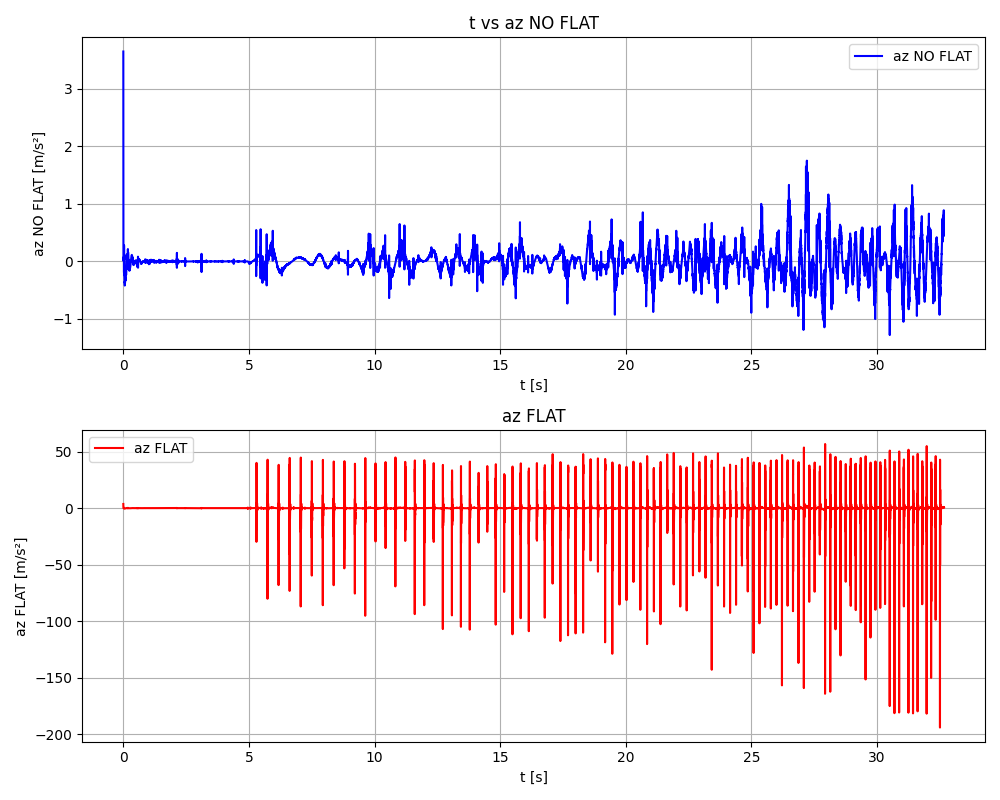

In [166]:
# Crear los subplots
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

# Primer subplot: t vs az_no_flat_array
axs[0].plot(t, az_no_flat, label='az NO FLAT', color='b')
axs[0].set_title('t vs az NO FLAT')
axs[0].set_xlabel('t [s]')
axs[0].set_ylabel('az NO FLAT [m/s²]')
axs[0].grid(True)
axs[0].legend()

# Segundo subplot: az_no_flat_array
axs[1].plot(t,az_with_flat, label='az FLAT', color='r')
axs[1].set_title('az FLAT')
axs[1].set_xlabel('t [s]')
axs[1].set_ylabel('az FLAT [m/s²]')
axs[1].grid(True)
axs[1].legend()

# Ajustar el layout
plt.tight_layout()

# Mostrar los gráficos
plt.show()

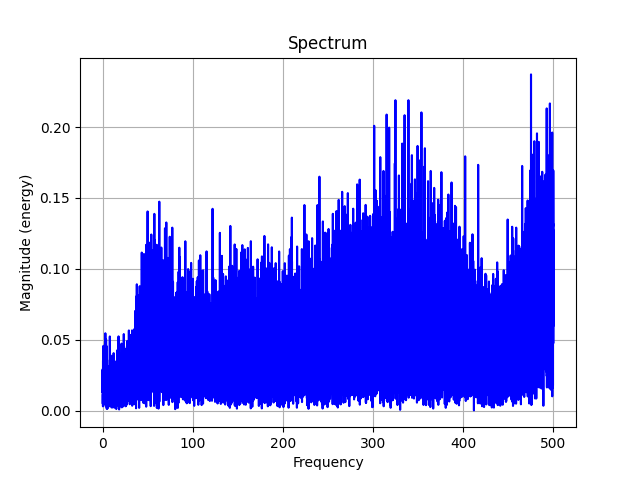

Max freq: 475.09351505499797


In [128]:
plt.close('all')
%matplotlib widget 
plt.title("Spectrum")
spectrum=plt.magnitude_spectrum(az_with_flat, Fs=fs, color='blue')
if index<2:
    for i in range(1, 100):
        plt.axvline(x=i*fr, color='red', linestyle='--', label=f'{i}*fr' if i == 1 else None)
plt.grid(True)
plt.show()

print('Max freq:',spectrum[1][np.argmax(spectrum[0])])

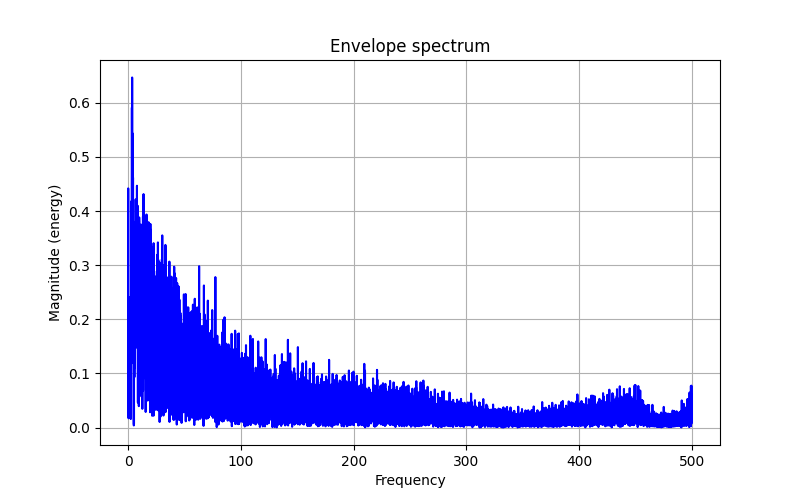

In [129]:
plt.close('all')
Sx_flat_env=np.abs(signal.hilbert(az_with_flat))
%matplotlib widget 
#%matplotlib inline
plt.figure(figsize=(8,5))
plt.title("Envelope spectrum")
spectrum=plt.magnitude_spectrum(Sx_flat_env-np.mean(Sx_flat_env), Fs=fs, color='blue')
if index<2:
    for i in range(1, 20):
        plt.axvline(x=i*fr, color='red', linestyle='--', label=f'{i}*fr' if i == 1 else None)
plt.grid(True)
#plt.savefig('prueba_rm.pdf',bbox_inches='tight')
plt.show()

In [130]:
Λ=10
D_lambda=1/16
K=int(Λ/D_lambda)
Ts=1/fs
λs=np.arange(0,Λ,D_lambda)
print('K:',K)
print(len(f_fail))
print(Ts)

K: 160
27001
0.001


In [131]:
G=np.zeros((K,N),dtype=np.complex128)
for k in range(K):
    G[k,:]=np.exp(-1j*2*np.pi*D_lambda*k*Ts*np.cumsum(f_fail))

G.shape

(160, 27001)

In [132]:
Sx_flat_env=Sx_flat_env-np.mean(Sx_flat_env)
Sx_env_analytic=signal.hilbert(Sx_flat_env)
Sx_env_analytic.shape

(27001,)

In [133]:
#X_lambda = (1/N)*np.dot(G, Sx_env_analytic)
X_lambda = calc_Xlambda(G,Sx_env_analytic)

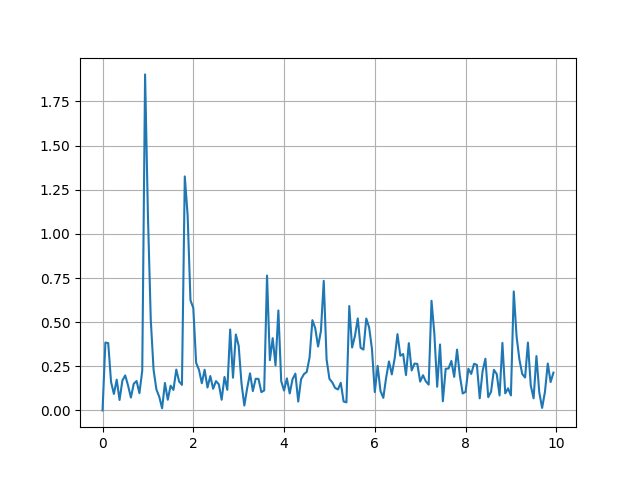

In [134]:
plt.close('all')
%matplotlib widget

plt.plot(λs,np.abs(X_lambda))
plt.grid(True)

---

In [169]:
index = 1

t = WF_Sx[index]['t [s]'].to_numpy()
az_no_flat = WF_Sx[index]['az NO FLAT [m/s2]'].to_numpy()
az_with_flat = WF_Sx[index]['az WITH FLAT [m/s2]'].to_numpy()

az_no_flat = az_no_flat - np.mean(az_no_flat)
az_with_flat = az_with_flat - np.mean(az_with_flat)

fs=1e3
N=len(t)
n=np.arange(N)

if index < 2:
    v=20e3/3600
    r=0.46
    fr=v/(2*np.pi*r)
    f_fail=fr*np.ones((N,1))
else:
    #N_samles_2=32670 
    v_var=1e3*np.linspace(23.5,57.8,N)
    fr_var=v_var[-1*N:]/(3600*2*np.pi*r)
    f_fail=fr_var.copy()

Sx_flat_env=np.abs(signal.hilbert(az_with_flat))


In [168]:
X_lambda_0 = matricial_IGD(f_fail, fs, Sx_flat_env)

In [170]:
X_lambda_1 = matricial_IGD(f_fail, fs, Sx_flat_env)

In [155]:
X_lambda_2 = matricial_IGD(f_fail, fs, Sx_flat_env)

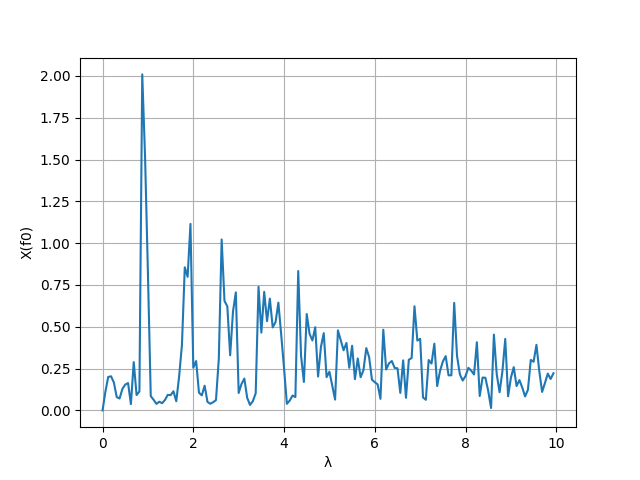

In [161]:
plt.close('all')
%matplotlib widget

λs=np.arange(0,Λ,D_lambda)

plt.plot(λs,np.abs(X_lambda_2))
plt.xlabel('λ')
plt.ylabel('X(f0)')
plt.grid(True)

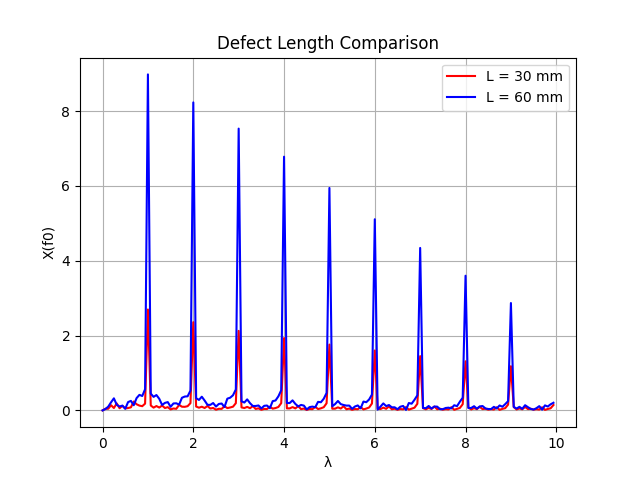

In [171]:
plt.close('all')
%matplotlib widget

λs=np.arange(0,Λ,D_lambda)

plt.plot(λs,np.abs(X_lambda_0),color='r')
plt.plot(λs,np.abs(X_lambda_1),color='b')
plt.legend(['L = 30 mm','L = 60 mm'])
plt.xlabel('λ')
plt.ylabel('X(f0)')
plt.title("Defect Length Comparison") 
plt.grid(True)

In [83]:
WF_Sx[-1].tail()

,t [s],az NO FLAT [m/s2],az WITH FLAT [m/s2]
32666,32.666,-9.044627,-9.042926
32667,32.667,-9.052778,-9.004735
32668,32.668,-9.007271,-9.034662
32669,32.669,-8.987924,-8.993435
32670,32.670,-8.975827,-9.044008


Min freq: 2.5892603281387316
Max freq: 5.766483445358526


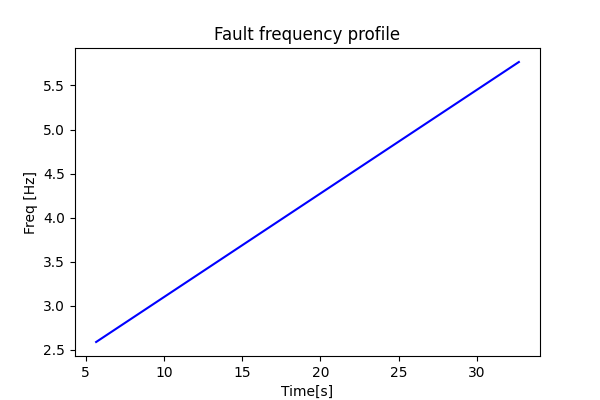

In [151]:
plt.close('all')
%matplotlib widget
plt.figure(figsize=(6,4)) ### change tuple for better visualization or change inline for qt in %matplotlib inline 
plt.plot(t,f_fail,color='blue')
plt.title('Fault frequency profile')
plt.xlabel('Time[s]')
plt.ylabel('Freq [Hz]')
print('Min freq:',np.min(f_fail))
print('Max freq:',np.max(f_fail))